# Resampling with Satpy

This notebook will show all the resampling methods Satpy can handle.

Set some environment variables for performance tweaking

In [2]:
import os
os.environ['PYTROLL_CHUNK_SIZE'] = "1024"
os.environ['DASK_NUM_WORKERS'] = "4"
os.environ['OMP_NUM_THREADS'] = "1"

Import Satpy and read some data.

In [177]:
from satpy import Scene
from satpy.resample import get_area_def
import glob

fnames = glob.glob("/home/lahtinep/data/satellite/new/*201909031245*")
scn = Scene(reader='seviri_l1b_hrit', filenames=fnames)
scn.load([10.8])
data = scn[10.8]

## Nearest neighbour resampling

With nearest neighbor resampling we can benefit from storing the resampling look-up tables to a cache directory. To see the performance difference for the initial and subsequent runs, we'll perform the same resampling twice and measure the run times for each round.

The `radius_of_influence` is used so that there are no gaps in the northern areas due to source data sparsity.

In [178]:
%%time
res = scn.resample('euron1', resampler='nearest',
                   radius_of_influence=50e3, cache_dir='/tmp')
res.save_dataset(10.8, filename='/tmp/nearest.tif')

CPU times: user 35.2 s, sys: 390 ms, total: 35.6 s
Wall time: 28.9 s


In [179]:
%%time
res = scn.resample('euron1', resampler='nearest', radius_of_influence=50e3, cache_dir='/tmp')
res.save_dataset(10.8, filename='/tmp/nearest.tif')

CPU times: user 8.41 s, sys: 232 ms, total: 8.64 s
Wall time: 7.96 s


## Bilinear resampling

The nearest neighbour interpolation creates rough features near the edges of the geostationary disk. This can be counteracted by using bilinear intepolation, which creates smoother results. Again, we get huge benefit from caching.

NOTE: the first run will take several minutes (8 minutes on the authors computer) and use a lot of memory (~16 GB).

In [180]:
%%time
res = scn.resample('euron1', resampler='bilinear',
                   radius_of_influence=50e3, cache_dir='/tmp')
res.save_dataset(10.8, filename='/tmp/bilinear.tif')

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtine

CPU times: user 12min 52s, sys: 3min 6s, total: 15min 59s
Wall time: 8min 23s


With the precalculated resampling indices the process should take 10-30 seconds depending on the machine.

In [181]:
%%time
res = scn.resample('euron1', resampler='bilinear',
                   radius_of_influence=50e3, cache_dir='/tmp')
res.save_dataset(10.8, filename='/tmp/bilinear.tif')

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/array/core.py:3914: RuntimeWarning: invalid value encountered in less
  result = function(*args, **kwargs)
/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/array/core.py:3914: RuntimeWarning: invalid value encountered in greater
  result = function(*args, **kwargs)


CPU times: user 45.2 s, sys: 6.27 s, total: 51.5 s
Wall time: 20.2 s


Now compare the saved images `/tmp/nearest.tif` and `/tmp/bilinear.tif` to see the differences especially in the northern regions.

## Bucket resamplers

The bucket resampling collects data into the closest target area pixels, or bins, or "buckets". Each source pixel can end up in only one target pixel. Distributing the data in fractions to different bins based on the footprint hasn't been implemented (yet).

As the nature of these resamplers is to aggregate data to lower resolution, we'll use high(er) resolution data with a low resolution target area.

Load the higher resolution HRV channel for better coverage.

In [182]:
scn = Scene(reader='seviri_l1b_hrit', filenames=fnames)
scn.load(['HRV'])
data = scn['HRV']
source_adef = data.attrs['area']

/home/lahtinep/Software/pytroll/packages/pyresample/pyresample/geometry.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  self.pixel_size_y = (area_extent[3] - area_extent[1]) / float(height)


First, lets count the number of source values ending up in each of the target bins. This can be used e.g. to aggregate lightning data to be used as an overlay.

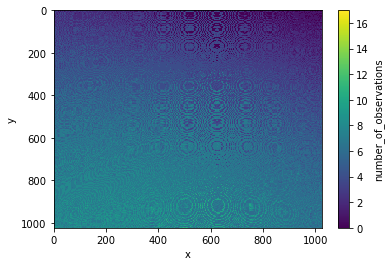

In [194]:
res = scn.resample('euro4', resampler='bucket_count')
res['HRV'].plot.imshow(origin='upper')

Next, compute the sum of values within the target bins. This in turn can be used e.g. for resampling already aggregated lightning data (cumulated flashes) which is in different projection. The data used here isn't very meaningufl, but can be used to demonstrate the usage.

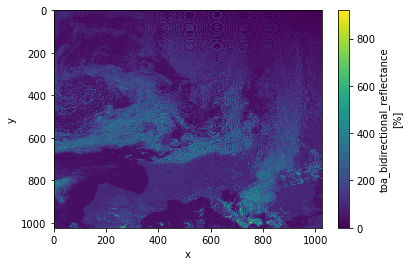

In [195]:
res = scn.resample('euro4', resampler='bucket_sum')
res['HRV'].plot.imshow(origin='upper')

For this data, a more meaningful result is the average. This could be calculated from the above two results, but for efficiency and ease of use we have it as a self contained resampler:

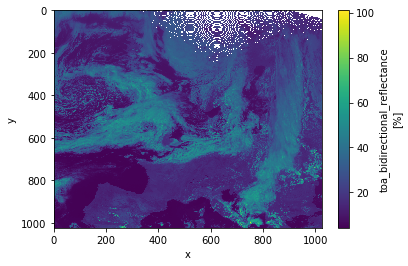

In [196]:
res = scn.resample('euro4', resampler='bucket_avg')
res['HRV'].plot.imshow(origin='upper')

The white circles at the top are formed by pixels where no data were present. This behaviour is inherent in the resampler.

The fourth bucket resampler can be used to calculate fractions of categorical (integer) data in each target pixel. This could be used for example to calculate the water fraction from high resolution data.

Form some categorical data from the HRV channel.

In [197]:
import numpy as np
# Digitize the data to nearest 20 reflectance units
data_int = 20. * (data.data / 20.).astype(np.uint8)
# Replace the HRV channel data
scn['HRV'].data = data_int

In [199]:
res = scn.resample('euro4', resampler='bucket_fraction',
                   categories=[60, 80, 100])

The different categories are now a new coordinate for the data, and can be used to select the da.

In [209]:
res['HRV']

<xarray.DataArray 'stack-ff5f3f433a8571812ac25fa3145090ee' (categories: 3, y: 1024, x: 1024)>
dask.array<stack, shape=(3, 1024, 1024), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * categories  (categories) int64 60 80 100
Dimensions without coordinates: y, x
Attributes:
    satellite_longitude:      0.0
    satellite_latitude:       0.0
    satellite_altitude:       35785831.0
    orbital_parameters:       {'projection_longitude': 0.0, 'projection_latit...
    sensor:                   seviri
    georef_offset_corrected:  True
    units:                    
    wavelength:               (0.5, 0.7, 0.9)
    platform_name:            Meteosat-11
    standard_name:            area_fraction
    start_time:               2019-09-03 12:45:10.495000
    end_time:                 2019-09-03 12:57:43.345000
    area:                     Area ID: euro4\nDescription: Euro 4km area - Eu...
    name:                     HRV
    resolution:               1000.13

/home/lahtinep/Software/miniconda3/envs/test/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


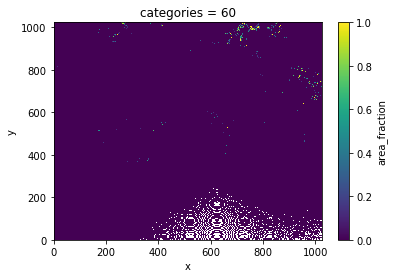

In [205]:
res['HRV'].sel(categories=60).plot.imshow(origin='upper')